In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
!pip install ucimlrepo
!pip install torch
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from ucimlrepo import fetch_ucirepo
import numpy as np
from scipy.stats import uniform, randint
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
from model_wizard import buscar_melhor_wisard
from metricas import plot_confusion_matrix, classification_metrics
from tratamento_dados import preprocess_data

## Quarto Dataset

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
letter_recognition = fetch_ucirepo(id=59) 
  
# data (as pandas dataframes) 
X = letter_recognition.data.features 
y = letter_recognition.data.targets 
  
# metadata 
print(letter_recognition.metadata) 
  
# variable information 
print(letter_recognition.variables) 


{'uci_id': 59, 'name': 'Letter Recognition', 'repository_url': 'https://archive.ics.uci.edu/dataset/59/letter+recognition', 'data_url': 'https://archive.ics.uci.edu/static/public/59/data.csv', 'abstract': 'Database of character image features; try to identify the letter', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 20000, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['lettr'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1991, 'last_updated': 'Thu Sep 28 2023', 'dataset_doi': '10.24432/C5ZP40', 'creators': ['David Slate'], 'intro_paper': None, 'additional_info': {'summary': 'The objective is to identify each of a large number of black-and-white rectangular pixel displays as one of the 26 capital letters in the English alphabet.  The character images were based on 20 different fonts and each letter within these 20 fonts wa

### Visualização de datasets

In [5]:
import numpy as np
print("Features:")
print(X.head())
print("\nTargets únicos:")
print(np.unique(y))

# Identificar colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

print("\nColunas categóricas:", categorical_cols)
print("Colunas numéricas:", numeric_cols)

Features:
   x-box  y-box  width  high  onpix  x-bar  y-bar  x2bar  y2bar  xybar  x2ybr  \
0      2      8      3     5      1      8     13      0      6      6     10   
1      5     12      3     7      2     10      5      5      4     13      3   
2      4     11      6     8      6     10      6      2      6     10      3   
3      7     11      6     6      3      5      9      4      6      4      4   
4      2      1      3     1      1      8      6      6      6      6      5   

   xy2br  x-ege  xegvy  y-ege  yegvx  
0      8      0      8      0      8  
1      9      2      8      4     10  
2      7      3      7      3      9  
3     10      6     10      2      8  
4      9      1      7      5     10  

Targets únicos:
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']

Colunas categóricas: []
Colunas numéricas: ['x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'x

### Tratamento de Dados

In [6]:
print("X shape original:", X.shape)
print("y shape original:", y.shape)

# Ajusta y se for DataFrame (transforma em Series)
if isinstance(y, pd.DataFrame):
    y = y.squeeze()

# Pré-processamento
X_processed, y_encoded, le = preprocess_data(X, y, categorical_cols, numeric_cols)

print("X_processed shape:", X_processed.shape)
print("y_encoded shape:", y_encoded.shape)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Exibe shapes
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)
print("Tamanho dos rótulos de treino:", y_train.shape)
print("Tamanho dos rótulos de teste:", y_test.shape)

# Exibe exemplos
print("\nExemplo de X_train (primeiras 5 linhas):")
print(X_train[:5])

print("\nExemplo de y_train (primeiros 5 rótulos):")
print(y_train[:5])

print("\nExemplo de X_test (primeiras 5 linhas):")
print(X_test[:5])

print("\nExemplo de y_test (primeiros 5 rótulos):")
print(y_test[:5])


X shape original: (20000, 16)
y shape original: (20000, 1)
X_processed shape: (20000, 128)
y_encoded shape: (20000,)
Tamanho do conjunto de treino: (14000, 128)
Tamanho do conjunto de teste: (6000, 128)
Tamanho dos rótulos de treino: (14000,)
Tamanho dos rótulos de teste: (6000,)

Exemplo de X_train (primeiras 5 linhas):
[[1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0
  0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0
  1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
  0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0]
 [1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0
  1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1
  0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0]
 [1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0
  0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0

#### Métricas

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Treinando WiSARD com n_classes=26, entry_size=128, tuple_size=11, bleaching=False
Melhores parâmetros encontrados: {'wisard__tuple_size': 11, 'wisard__bleaching': False}
Melhor acurácia: 0.4310737494624488


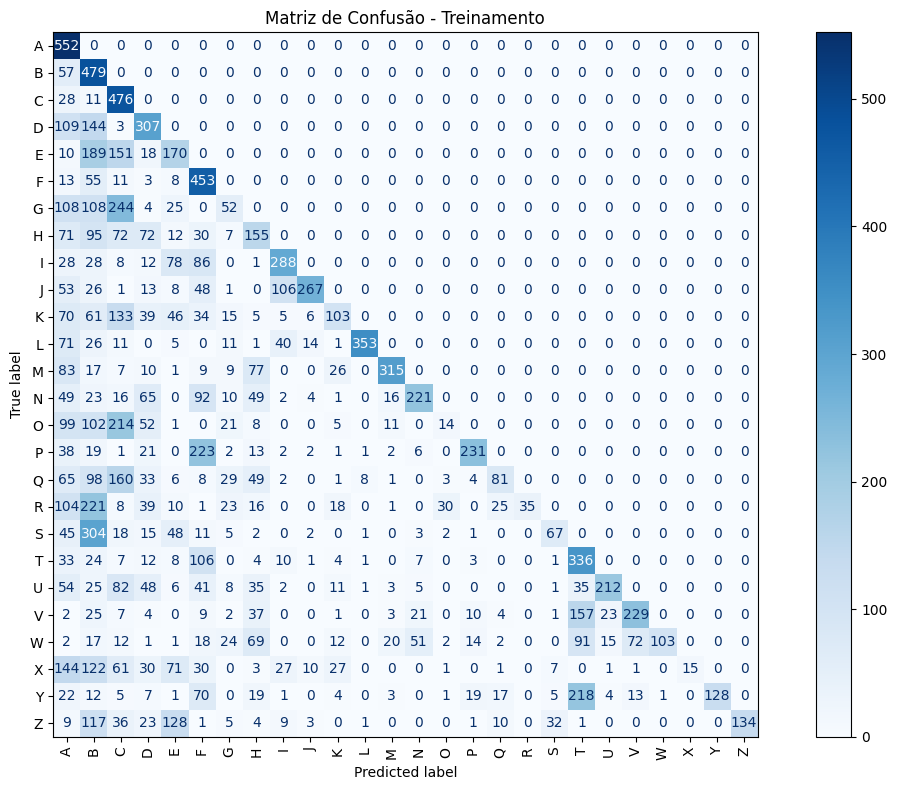

              precision    recall  f1-score   support

           A       0.29      1.00      0.45       552
           B       0.20      0.89      0.33       536
           C       0.27      0.92      0.42       515
           D       0.37      0.55      0.44       563
           E       0.27      0.32      0.29       538
           F       0.36      0.83      0.50       543
           G       0.23      0.10      0.14       541
           H       0.28      0.30      0.29       514
           I       0.58      0.54      0.56       529
           J       0.86      0.51      0.64       523
           K       0.48      0.20      0.28       517
           L       0.96      0.66      0.79       533
           M       0.84      0.57      0.68       554
           N       0.70      0.40      0.51       548
           O       0.26      0.03      0.05       527
           P       0.82      0.41      0.55       562
           Q       0.58      0.15      0.24       548
           R       1.00    

In [7]:

best_model, best_params, best_score, random_search = buscar_melhor_wisard(X_train, y_train)

print("Melhores parâmetros encontrados:", best_params)
print("Melhor acurácia:", best_score)

# Faz predição codificada
y_train_pred_encoded = random_search.predict(X_train)

# Plota matriz de confusão com labels na vertical
plot_confusion_matrix(y_train, y_train_pred_encoded, le, title="Matriz de Confusão - Treinamento")

# Imprime relatório de classificação com rótulos originais
classification_metrics(y_train, y_train_pred_encoded, le)

### Predição

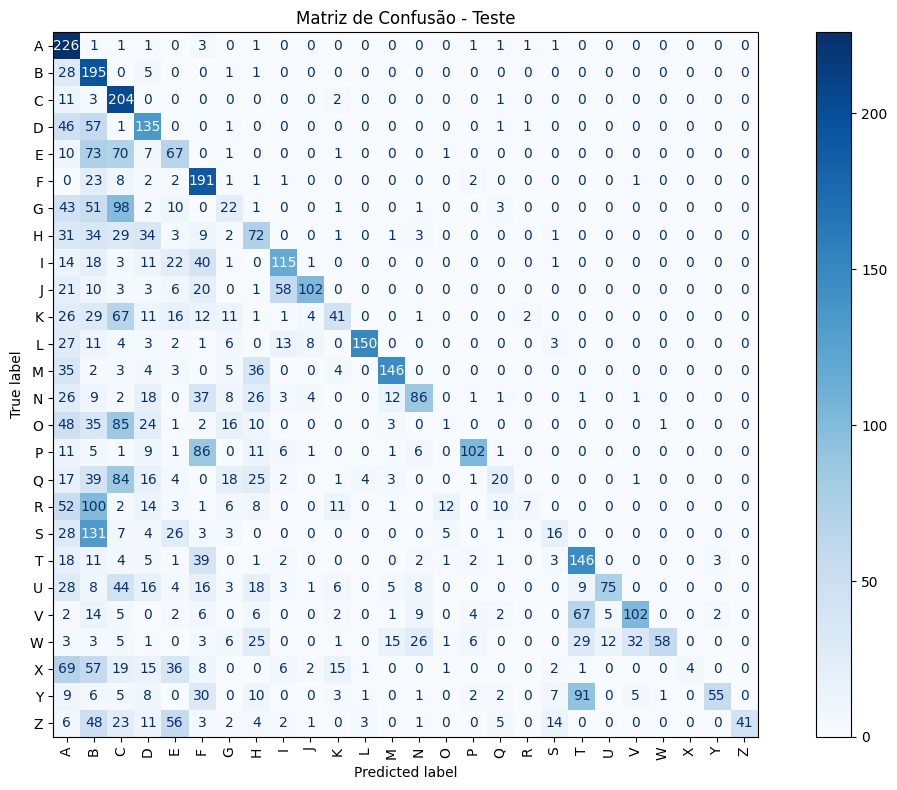

              precision    recall  f1-score   support

           A       0.27      0.95      0.42       237
           B       0.20      0.85      0.32       230
           C       0.26      0.92      0.41       221
           D       0.38      0.56      0.45       242
           E       0.25      0.29      0.27       230
           F       0.37      0.82      0.51       232
           G       0.19      0.09      0.13       232
           H       0.28      0.33      0.30       220
           I       0.54      0.51      0.53       226
           J       0.82      0.46      0.59       224
           K       0.46      0.18      0.26       222
           L       0.94      0.66      0.78       228
           M       0.78      0.61      0.69       238
           N       0.60      0.37      0.45       235
           O       0.05      0.00      0.01       226
           P       0.84      0.42      0.56       241
           Q       0.41      0.09      0.14       235
           R       0.64    

In [8]:
# Predição no teste
y_test_pred = random_search.predict(X_test)

plot_confusion_matrix(y_test, y_test_pred, le, title="Matriz de Confusão - Teste")
classification_metrics(y_test, y_test_pred, le)